In [1]:
from fastai.imports import *
from fastai.tabular import *
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from IPython.display import display
from sklearn import metrics
import requests
import pandas as pd
from pandas_gbq import to_gbq
import json
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import geopandas as gpd
from shapely.geometry import Point, LineString
import matplotlib.pyplot as plt
import os
from google.cloud import bigquery
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import FunctionTransformer
from pandas import to_datetime
from sklearn.model_selection import train_test_split

# Data pull

In [2]:
from google.colab import files
uploaded = files.upload()

Saving open-data-2024-78df73c35291.json to open-data-2024-78df73c35291 (1).json


In [3]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/content/open-data-2024-78df73c35291.json"

# Construct a BigQuery client object.
client = bigquery.Client()

# Query to pull data from BigQuery
query = """
SELECT * FROM
`open-data-2024.nyc_motor_vechicle_crashes.collisions_with_open_streets`
where crash_date >= '2023-01-01'
"""
query_job = client.query(query)

# Store the data in a pandas DataFrame
collisions = query_job.to_dataframe()

#Gradient Boost Regression Tree

## Training

In [4]:
# create target variables
collisions['total_number_of_casualties'] = collisions['number_of_persons_injured'] + collisions['number_of_persons_killed']

# clean up features
collisions['is_open_street'] = collisions['is_open_street'].astype(int)
collisions['crash_during_open_street'] = collisions['crash_during_open_street'].astype(int)
# Convert 'crash_datetime' to datetime format if not already
collisions['crash_datetime'] = to_datetime(collisions['crash_datetime'])

# Extracting features from 'crash_datetime'
collisions['day_of_week'] = collisions['crash_datetime'].dt.dayofweek  # Monday=0, Sunday=6
collisions['hour_of_day'] = collisions['crash_datetime'].dt.hour  # 0 to 23
collisions['month'] = collisions['crash_datetime'].dt.month  # 1 to 12

In [168]:
# Defining the features and target variable for the model
#features = ['latitude', 'longitude', 'is_open_street', 'crash_during_open_street', 'day_of_week', 'hour_of_day', 'month']


# Splitting the dataset into training and testing sets


In [19]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import PolynomialFeatures, KBinsDiscretizer


# Impute missing values in the target variable (y_train)
target_imputer = SimpleImputer(strategy='mean')  # Using mean strategy; adjust as needed for your target


# Feature Engineering: Interaction Terms and Polynomial Features

# 2. Binning 'hour_of_day' into categories (morning, afternoon, evening, night)
# Define bin edges and labels
bins = [0, 6, 12, 18, 24]
labels = ['night', 'morning', 'afternoon', 'evening']
kbins = KBinsDiscretizer(n_bins=4, encode='onehot-dense', strategy='uniform')
hour_of_day_binned = kbins.fit_transform(collisions[['hour_of_day']])
# Create a DataFrame for the binned hours with appropriate column names
hour_of_day_binned_df = pd.DataFrame(hour_of_day_binned, columns=labels)

# Combine all engineered features with the original DataFrame (for simplicity, assuming original df is ready for these operations)
#df_engineered = df.join([lat_long_poly_df, hour_of_day_binned_df])
# Now, combining the DataFrame again with the corrected polynomial features DataFrame
collisions_engineered = pd.concat([collisions, lat_long_poly_df, hour_of_day_binned_df], axis=1)

# Define numerical and categorical features
numerical_features = ['latitude', 'longitude', 'day_of_week', 'hour_of_day','night']
categorical_features = ['crash_during_open_street']

# Imputers for numerical and categorical data
numerical_imputer = SimpleImputer(strategy='mean')
categorical_imputer = SimpleImputer(strategy='most_frequent')


# Preprocessor for handling both numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_imputer, numerical_features),
        ('cat', categorical_imputer, categorical_features),
    ])



# Update feature list for the model
# Make sure to exclude any original features replaced or not needed after engineering
engineered_features = numerical_features + categorical_features

X = collisions_engineered[engineered_features]  # Features
y = collisions_engineered[target]  # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape y_train to fit the imputer expected format and perform imputation
y_train_imputed = target_imputer.fit_transform(y_train.values.reshape(-1, 1)).ravel()

# Now, you can use `y_train_imputed` for fitting the model instead of `y_train`
# Ensure the pipeline is defined as before, without the need to impute the target within it

In [20]:

# Pipeline to handle imputation and model fitting
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', GradientBoostingRegressor(random_state=42))
])

# Fit the pipeline to the data
pipeline.fit(X_train, y_train_imputed)

# Assuming X_train and y_train are already defined and include the correct columns and target variable.
# This code block handles NaN imputation and model fitting in a single step.


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', SimpleImputer(),
                                                  ['latitude', 'longitude',
                                                   'day_of_week', 'hour_of_day',
                                                   'night']),
                                                 ('cat',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['crash_during_open_street'])])),
                ('model', GradientBoostingRegressor(random_state=42))])

## Evaluating the model

In [21]:
# Predict on the test set
y_pred = pipeline.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared: {r2}")

Mean Absolute Error (MAE): 6.404124165760607
Mean Squared Error (MSE): 73.3748458987699
R-squared: 0.011010375051969667


### Feature importance

In [17]:
feature_importances = pipeline.named_steps['model'].feature_importances_

# Display feature importances
for feature, importance in zip(engineered_features, feature_importances):
    print(f"{feature}: {importance}")

latitude: 0.09235024296943331
longitude: 0.07131660926257545
is_open_street: 0.05021852671875871
crash_during_open_street: 0.1955027729953124
day_of_week: 0.052874049704128644
hour_of_day: 0.0011449375332897524
month: 0.0004821794772096314
crash_open_street_day_interaction: 6.523940051717055e-05
night: 0.3615003210371768
afternoon: 0.09381640813601921
evening: 0.07949922801201448
latitude longitude: 0.0
latitude^2: 0.0009573899505746044
longitude^2: 0.0002720948029899163


## random forest

In [22]:
from sklearn.ensemble import RandomForestRegressor

# Assuming the setup and data preparation is the same as before

# Update the model in the pipeline to use a RandomForestRegressor
pipeline_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),  # Keep the same preprocessor as before
    ('model', RandomForestRegressor(random_state=42))
])

# Fit the pipeline to the training data
pipeline_rf.fit(X_train, y_train_imputed)

# Predict on the test set
y_pred_rf = pipeline_rf.predict(X_test)

# Evaluate the model
mae_rf = mean_absolute_error(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest - Mean Absolute Error (MAE): {mae_rf}")
print(f"Random Forest - Mean Squared Error (MSE): {mse_rf}")
print(f"Random Forest - R-squared: {r2_rf}")

# Extracting feature importances from the Random Forest model
feature_importances_rf = pipeline_rf.named_steps['model'].feature_importances_

# Printing feature importances
for feature, importance in zip(engineered_features, feature_importances_rf):
    print(f"{feature}: {importance}")



Random Forest - Mean Absolute Error (MAE): 6.473593125248617
Random Forest - Mean Squared Error (MSE): 80.17501121054231
Random Forest - R-squared: -0.08064628001689145
latitude: 0.36602530442860776
longitude: 0.3741350613385332
day_of_week: 0.1239929896671644
hour_of_day: 0.13173697449131658
night: 0.0036253358970248163
crash_during_open_street: 0.0004843341773532669


# xgboost

In [33]:
from xgboost import XGBRegressor

pipeline_xgb = Pipeline([
    ('preprocessor', preprocessor),
    ('model', XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.2,
                max_depth = 10, alpha = 10, n_estimators = 100))
])

pipeline_xgb.fit(X_train, y_train_imputed)

# Predict on the test set
y_pred_xgb = pipeline_xgb.predict(X_test)

# Evaluate the model
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"Random Forest - Mean Absolute Error (MAE): {mae_xgb}")
print(f"Random Forest - Mean Squared Error (MSE): {mse_xgb}")
print(f"Random Forest - R-squared: {r2_xgb}")

# Extracting feature importances from the Random Forest model
feature_importances_xgb = pipeline_xgb.named_steps['model'].feature_importances_

# Printing feature importances
for feature, importance in zip(engineered_features, feature_importances_xgb):
    print(f"{feature}: {importance}")


Random Forest - Mean Absolute Error (MAE): 6.406812694149578
Random Forest - Mean Squared Error (MSE): 73.77083845348791
Random Forest - R-squared: 0.005672952896247807
latitude: 0.0692548006772995
longitude: 0.06804479658603668
day_of_week: 0.0113033102825284
hour_of_day: 0.36752569675445557
night: 0.43166598677635193
crash_during_open_street: 0.0522054061293602


# neural net

In [77]:
cont_names = ['latitude', 'longitude', 'day_of_week', 'hour_of_day', 'night', 'total_number_of_casualties']
cat_names = ['crash_during_open_street']
feats = cont_names + cat_names
collisions_engineered_small = collisions_engineered[feats].copy()

In [78]:
collisions_engineered_small.shape

(98957, 7)

In [79]:
collisions_engineered_small.dtypes

latitude                       object
longitude                      object
day_of_week                     int64
hour_of_day                     int64
night                         float64
total_number_of_casualties     object
crash_during_open_street        int64
dtype: object

In [80]:
collisions_engineered_small['latitude'] = collisions_engineered_small['latitude'].astype(float)
collisions_engineered_small['longitude'] = collisions_engineered_small['longitude'].astype(float)
collisions_engineered_small['total_number_of_casualties'] = collisions_engineered_small['total_number_of_casualties'].astype(int)

epoch,train_loss,valid_loss,mse,accuracy,time
0,69.060036,80.598129,80.598129,0.578900,00:15
1,69.658409,79.685448,79.685448,0.578900,00:16
2,67.711586,80.245911,80.245911,0.578900,00:15
3,71.960381,79.705696,79.705696,0.578900,00:15
4,68.345917,79.691238,79.691238,0.578900,00:15


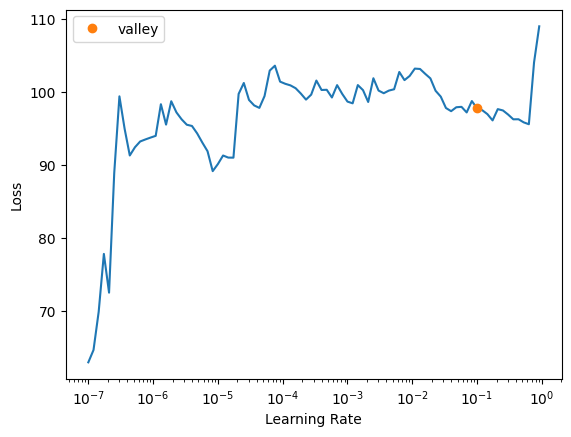

In [82]:
from fastai.tabular.all import *

# Assuming 'df' is your DataFrame and it's already preprocessed

df = collisions_engineered_small.copy()

# Step 2 & 3: Prepare the data and create DataLoaders
dls = TabularDataLoaders.from_df(df, path='.',procs=[Categorify, FillMissing, Normalize],
                                 y_names="total_number_of_casualties",
                                 cont_names = ['latitude', 'longitude', 'day_of_week', 'hour_of_day', 'night'],
                                 cat_names = ['crash_during_open_street'],
                                 y_block=RegressionBlock(),
                                 bs=64 # Batch size
                                 ) # Split data for training and validation

# Step 4: Define and Train the Model
learn = tabular_learner(dls, layers=[200,100], metrics=[mse, accuracy]) # Customize layers as needed

# Find an appropriate learning rate
learn.lr_find()

# Train the model
learn.fit_one_cycle(5, 1e-2) # Number of epochs and learning rate


In [74]:
dls.show_batch()


,crash_during_open_street,latitude,longitude,day_of_week,hour_of_day,night
0,0,40.796719,-73.976181,6.000000e+00,7.0,-4.953139e-09
1,0,40.681297,-73.934723,3.000000e+00,13.0,-4.953139e-09
2,0,40.868248,-73.916145,-6.297906e-08,22.0,-4.953139e-09
3,0,40.898159,-73.874817,4.000000e+00,19.0,-4.953139e-09
4,0,40.614269,-74.156654,4.000000e+00,13.0,-4.953139e-09
5,0,40.700592,-73.854568,3.000000e+00,16.0,-4.953139e-09
6,0,40.856308,-73.859901,6.000000e+00,9.0,-4.953139e-09
7,0,40.792931,-73.947906,-6.297906e-08,22.0,-4.953139e-09
8,0,40.646988,-73.969315,3.000000e+00,12.0,-4.953139e-09
9,0,40.664097,-73.909317,4.000000e+00,15.0,-4.953139e-09


# next steps
Feature Engineering:

* Interaction Terms: Create interaction terms between features that might have
combined effects on the target variable, such as combining latitude and longitude or is_open_street with day_of_week or hour_of_day.

* Polynomial Features: For numerical features like latitude and longitude, consider generating polynomial features to capture more complex spatial relationships.

* Time Features: Even though hour_of_day had no importance, you might want to revisit how time is represented or interacted with other features. Binning hours into time of day (morning, afternoon, evening) might capture behavioral patterns better.


In [196]:
from sklearn.preprocessing import PolynomialFeatures, KBinsDiscretizer

# Feature Engineering: Interaction Terms and Polynomial Features

# 1. Polynomial Features for latitude and longitude to capture spatial relationships
poly = PolynomialFeatures(degree=2, include_bias=False)
lat_long_poly = poly.fit_transform(collisions[['latitude', 'longitude']])
# Create a DataFrame for the polynomial features with appropriate column names
lat_long_poly_df = pd.DataFrame(lat_long_poly, columns=poly.get_feature_names_out(['latitude', 'longitude']))
lat_long_poly_df = lat_long_poly_df.drop('latitude', axis=1)
lat_long_poly_df = lat_long_poly_df.drop('longitude', axis=1)

# 2. Binning 'hour_of_day' into categories (morning, afternoon, evening, night)
# Define bin edges and labels
bins = [0, 6, 12, 18, 24]
labels = ['night', 'morning', 'afternoon', 'evening']
kbins = KBinsDiscretizer(n_bins=4, encode='onehot-dense', strategy='uniform')
hour_of_day_binned = kbins.fit_transform(collisions[['hour_of_day']])
# Create a DataFrame for the binned hours with appropriate column names
hour_of_day_binned_df = pd.DataFrame(hour_of_day_binned, columns=labels)

# 3. Interaction Terms: For simplicity, let's create an interaction term between 'is_open_street' and 'day_of_week'
collisions['crash_open_street_day_interaction'] = collisions['crash_during_open_street'] * collisions['day_of_week']

# Combine all engineered features with the original DataFrame (for simplicity, assuming original df is ready for these operations)
#df_engineered = df.join([lat_long_poly_df, hour_of_day_binned_df])
# Now, combining the DataFrame again with the corrected polynomial features DataFrame
collisions_engineered = pd.concat([collisions, lat_long_poly_df, hour_of_day_binned_df], axis=1)

# Update feature list for the model
# Make sure to exclude any original features replaced or not needed after engineering
engineered_features = features + ['crash_open_street_day_interaction','night','afternoon', 'evening', 'latitude longitude', 'latitude^2', 'longitude^2']

In [205]:
collisions_engineered[engineered_features].columns

Index(['latitude', 'longitude', 'is_open_street', 'crash_during_open_street',
       'day_of_week', 'hour_of_day', 'month',
       'crash_open_street_day_interaction', 'night', 'afternoon', 'evening',
       'latitude longitude', 'latitude^2', 'longitude^2'],
      dtype='object')

In [206]:
def list_duplicates(seq):
  seen = set()
  seen_add = seen.add
  # adds all elements it doesn't know yet to seen and all other to seen_twice
  seen_twice = set( x for x in seq if x in seen or seen_add(x) )
  # turn the set into a list (as requested)
  return list( seen_twice )

list_duplicates(collisions_engineered[engineered_features].columns)
#collisions_engineered = collisions_engineered.drop(collisions_engineered.columns[69], axis=1)
#collisions_engineered = collisions_engineered.drop(collisions_engineered.columns[70], axis=1)

[]

In [208]:
# Update the model pipeline to include these new features
# Note: This example assumes the preprocessor and model setup remains the same and focuses on feature engineering
pipeline = Pipeline([
    ('preprocessor', preprocessor),  # Assuming preprocessor is already defined and appropriate
    ('model', GradientBoostingRegressor(random_state=42))
])

# You need to split your engineered DataFrame into training and testing sets again
X_train_eng, X_test_eng, y_train_eng, y_test_eng = train_test_split(collisions_engineered[engineered_features], collisions_engineered['total_number_of_casualties'], test_size=0.2, random_state=42)

# Fit the pipeline to the data with the engineered features
pipeline.fit(X_train_eng, y_train_eng)

# Note: This code assumes df is your DataFrame and that it's prepared for these operations.
# Adjustments might be needed based on your actual DataFrame structure and preprocessing

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', SimpleImputer(),
                                                  ['latitude', 'longitude',
                                                   'day_of_week', 'hour_of_day',
                                                   'month']),
                                                 ('cat',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['is_open_street',
                                                   'crash_during_open_street'])])),
                ('model', GradientBoostingRegressor(random_state=42))])

In [210]:
# Predict on the test set
y_pred_eng = pipeline.predict(X_test_eng)

# Evaluate the model
mae_eng = mean_absolute_error(y_test_eng, y_pred_eng)
mse_eng = mean_squared_error(y_test_eng, y_pred_eng)
r2_eng = r2_score(y_test_eng, y_pred_eng)

print(f"Mean Absolute Error (MAE): {mae_eng} ")
print(f"Mean Squared Error (MSE): {mse_eng}")
print(f"R-squared: {r2_eng}")

Mean Absolute Error (MAE): 6.396311983908567 6.396311983908567 
Mean Squared Error (MSE): 73.30298516044543
R-squared: 0.011978956638390437


In [185]:
del features

In [188]:
# Assuming `engineered_features` correctly lists all the features used in the model training
engineered_features = ['latitude', 'longitude', 'is_open_street', 'crash_during_open_street',
                       'day_of_week', 'hour_of_day', 'month', 'open_street_day_interaction',
                       'night', 'morning', 'afternoon', 'evening',
                       'latitude*longitude', 'latitude^2', 'longitude^2']

# Extracting feature importances from the trained model
feature_importances = pipeline.named_steps['model'].feature_importances_

# Correctly printing feature names with their importances
for feature, importance in zip(engineered_features, feature_importances):
    print(f"{feature}: {importance}")


latitude: 0.32121846797755055
longitude: 0.3138040527985561
is_open_street: 0.03181761998111131
crash_during_open_street: 0.2574470338105909
day_of_week: 0.07349205417398845
hour_of_day: 0.0
month: 0.0022207712582025282


In [190]:
# Assuming 'pipeline' is your trained Pipeline object
# Assuming the transformation logic is encapsulated within the pipeline

# If you have a ColumnTransformer in your pipeline, you could extract transformed feature names:
# This is conceptual and might need adjustment based on your exact pipeline structure
if 'preprocessor' in pipeline.named_steps:
    transformers = pipeline.named_steps['preprocessor'].transformers_
    # This part needs customization based on your actual pipeline and transformations

# Direct approach to re-align:
# Manually ensure that 'engineered_features' includes ALL features passed to the model after preprocessing
# including those generated by PolynomialFeatures and any binning.

# Print feature importances correctly aligned with the actual features used in training
for feature, importance in zip(engineered_features, feature_importances):
    print(f"{feature}: {importance}")


latitude: 0.32121846797755055
longitude: 0.3138040527985561
is_open_street: 0.03181761998111131
crash_during_open_street: 0.2574470338105909
day_of_week: 0.07349205417398845
hour_of_day: 0.0
month: 0.0022207712582025282


## Spatial analysis?
- a new feature: how close the crash was to an open street?

## Predictions

In [ ]:
# Example: predict for a new observation
new_data = [[latitude, longitude, is_open_street, crash_during_open_street, day_of_week, hour_of_day, month]]
new_prediction = pipeline.predict(new_data)
print(f"Predicted number of casualties: {new_prediction[0]}")

# Deployment
- Save pickle